In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [2]:
dir_path = '../../../data/pseudobulks/'

In [3]:
os.listdir(dir_path)

['annotation_chimp.csv',
 'annotation_human.csv',
 'annotation_macaque.csv',
 'annotation_spatial_libd_human.csv',
 'expression_chimp.csv',
 'expression_human.csv',
 'expression_macaque.csv',
 'expression_mean_chimp.csv',
 'expression_mean_human.csv',
 'expression_mean_macaque.csv',
 'expression_mean_spatial_libd_human.csv',
 'expression_spatial_libd_human.csv',
 'expression_sum_chimp.csv',
 'expression_sum_human.csv',
 'expression_sum_macaque.csv',
 'expression_sum_spatial_libd_human.csv',
 'gene_sample_mean_chimp.csv',
 'gene_sample_mean_human.csv',
 'gene_sample_mean_macaque.csv',
 'gene_sample_mean_spatial_libd_human.csv',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_age_sample_norm_zscore.h5ad',
 'pb_mamm.h5ad',
 'pb_mamm_filtered.h5ad',
 'pb_mamm_sample_norm.h5ad',
 'pb_mamm_sample_norm_filtered.h5ad',
 'pb_mamm_sample_norm_zscore.h5ad',
 'pb_mamm_sample_zscore_filtered.h5ad']

# ANOVA

Load pseudobulk data

In [4]:
file_name = 'pb_mamm.h5ad'
adata_pb = sc.read_h5ad(dir_path + file_name)
adata_pb

AnnData object with n_obs × n_vars = 94 × 15585
    obs: 'layer', 'sample_id', 'condition'

Remove technical repeats and WM layers

In [5]:
adata_pb = adata_pb[(adata_pb.obs.sample_id != 'chimp_13302') & (adata_pb.obs.layer != 'WM')].copy()

In [6]:
adata_pb

AnnData object with n_obs × n_vars = 76 × 15585
    obs: 'layer', 'sample_id', 'condition'

Calculate library size

In [7]:
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

## Gene filltering

Fillter low expressed genes

In [8]:
adata_pb = adata_pb[:, adata_pb.X.mean(axis=0) > 0.05]
adata_pb

View of AnnData object with n_obs × n_vars = 76 × 9435
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'

In [9]:
adata_pb.write_h5ad('../../../data/pseudobulks/pb_mamm_laminar_filtered.h5ad')

## Sample normalization

In [10]:
def z_score(adata):
    pb_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
    pb_df['sample_id'] = adata.obs['sample_id']
    pb_df.head()
    # calculate statistics
    sample_mean = pb_df.groupby('sample_id').mean()
    sample_std = pb_df.groupby('sample_id').std()
    # calculate z-score
    columns = pb_df.columns.tolist()[:-1]
    for sample in tqdm(sample_mean.index.tolist()):
        pb_df.loc[pb_df.sample_id == sample, columns] = ((pb_df.loc[pb_df.sample_id == sample, columns] - sample_mean.loc[sample])
                                                         / sample_std.loc[sample]).fillna(0)
    # write adata
    adata.X = pb_df[columns].values
    return adata

Library normalization

In [11]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)

normalizing counts per cell
    finished (0:00:00)


D:\Projects\diploma\venv_stats2\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Sample normalization

In [12]:
adata_norm = z_score(adata_pb)

  0%|          | 0/13 [00:00<?, ?it/s]

In [13]:
sc.pp.pca(adata_norm)

computing PCA
    with n_comps=50
    finished (0:00:00)


In [14]:
# save results
adata_norm.write_h5ad('../../../data/pseudobulks/pb_mamm_laminar_sample_zscore_filtered.h5ad')

D:\Projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
D:\Projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


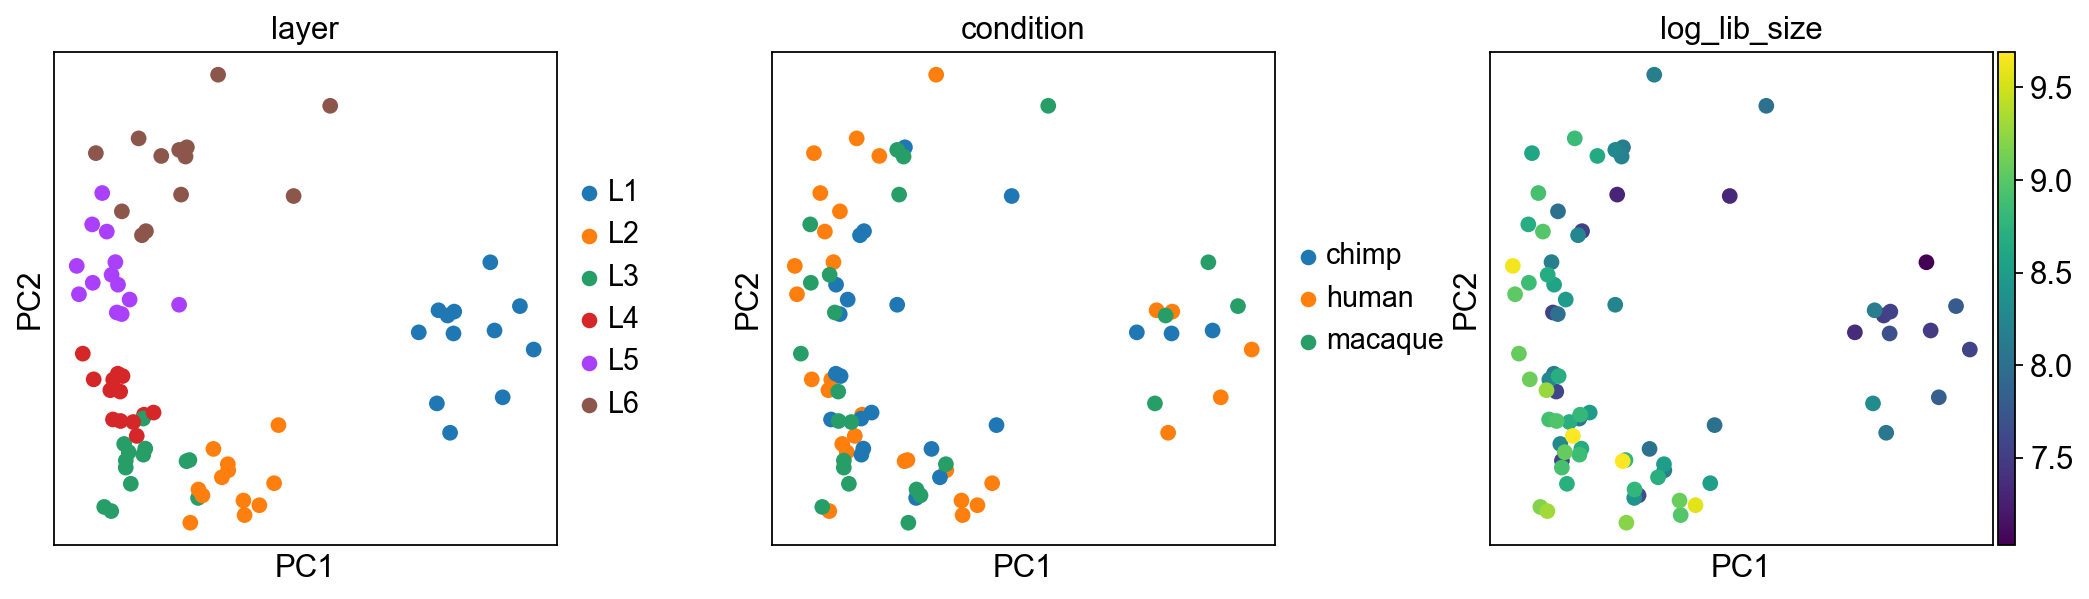

In [15]:
sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3, wspace=0.3)

## ANOVA

In [16]:
file_name = 'pb_mamm_laminar_sample_zscore_filtered.h5ad'
adata = sc.read_h5ad(dir_path + file_name)
adata

AnnData object with n_obs × n_vars = 76 × 9435
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [17]:
# Make df for ANOVA
df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
df['condition'] = adata.obs.condition
df['layer'] = adata.obs.layer
df.head()

,NOC2L,KLHL17,HES4,AGRN,SDF4,B3GALT6,UBE2J2,SCNN1D,ACAP3,PUSL1,...,SPATC1L,LSS,MCM3AP,YBEY,PCNT,DIP2A,S100B,PRMT2,condition,layer
L5.human_759,0.767870,1.279255,-1.101649,0.941529,-0.910852,1.900370,1.184966,-1.407523,0.493433,1.062110,...,1.042475,-0.140429,0.216547,1.421607,0.554831,0.680244,-0.497133,-0.346517,human,L5
L2.human_759,-0.028992,-1.612652,1.216243,-1.298306,0.850277,-0.268092,-0.947844,1.366723,-0.032614,-0.357564,...,0.516995,-1.111851,-1.343580,0.181097,-0.468474,-0.975243,-0.304843,0.759532,human,L2
L3.human_759,0.197133,-0.310825,0.059265,0.622130,-0.674575,-0.614929,0.207339,-0.715946,-1.044522,0.129490,...,-1.141345,-0.071219,1.594507,-0.972681,-0.246727,-1.079287,-0.482943,-0.711799,human,L3
L1.human_759,-1.890431,-0.357519,1.177696,-0.868319,0.989991,-0.424973,-1.273895,-0.221358,-0.404024,-1.795936,...,-0.926332,1.725510,-0.743337,0.492949,1.748707,0.999744,2.035575,1.183187,human,L1
L6.human_759,0.890422,0.365434,-0.635215,1.044826,-1.122353,0.243501,-0.171655,0.724665,-0.733619,0.340789,...,1.077530,0.382436,0.051769,-1.312018,-0.579182,1.009366,-0.401652,0.559139,human,L6


Replace gene names to `gene{i}` as `statsmodels` may fail

In [18]:
df_var_num = df.copy()
df_var_num.columns = [f'gene{i}' for i in range(1, df_var_num.shape[1] - 1)] + ['condition', 'layer']

In [19]:
# ANOVA for each gene
results = []

for gene in tqdm(df_var_num.columns.tolist()[:-2]):
    formula = f'{gene} ~ condition + layer + condition:layer'
    model = ols(formula, data=df_var_num).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    results.append(aov_table.loc['condition:layer'].tolist())

# save results to df
columns = ['sum_sq', 'df', 'F', 'PR(>F)']
res = pd.DataFrame(results, columns=columns, index=adata.var_names)
res.head()

  0%|          | 0/9435 [00:00<?, ?it/s]

,sum_sq,df,F,PR(>F)
NOC2L,5.221104,10.0,0.842126,0.590729
KLHL17,7.392538,10.0,1.756889,0.089652
HES4,10.147366,10.0,1.476590,0.171623
AGRN,11.209840,10.0,2.786144,0.006975
SDF4,12.915461,10.0,1.824119,0.076337


## Multiple comparison correction

In [20]:
# Multiple comparison correction
mult_test = multipletests(res['PR(>F)'], method='fdr_bh')
res['p_val_adj'] = mult_test[1]
res.to_csv(f'../../../results/DE/mammals/ANOVA_zscore_laminar/anova_zscore_mamm.csv')

In [21]:
res.head()

,sum_sq,df,F,PR(>F),p_val_adj
NOC2L,5.221104,10.0,0.842126,0.590729,0.673788
KLHL17,7.392538,10.0,1.756889,0.089652,0.181595
HES4,10.147366,10.0,1.476590,0.171623,0.282792
AGRN,11.209840,10.0,2.786144,0.006975,0.029890
SDF4,12.915461,10.0,1.824119,0.076337,0.162215


<Axes: >

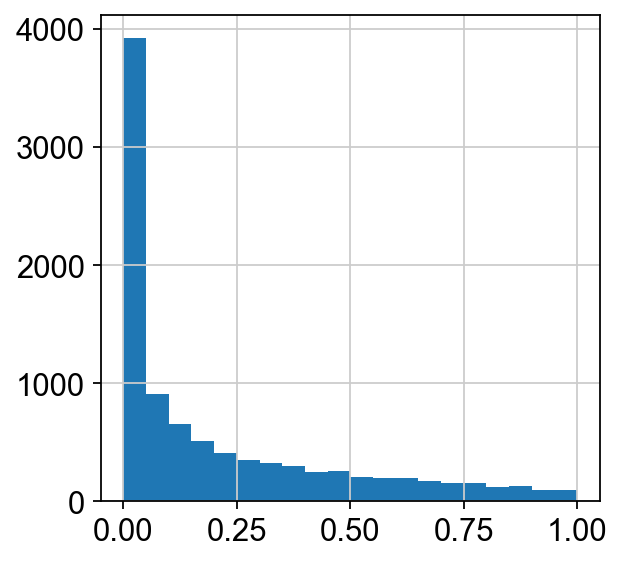

In [22]:
res['PR(>F)'].hist(bins=20)

## t-test

In [23]:
anova_res = pd.read_csv(f'../../../results/DE/mammals/ANOVA_zscore_laminar/anova_zscore_mamm.csv', index_col=0)
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
NOC2L,5.221104,10.0,0.842126,0.590729,0.673788
KLHL17,7.392538,10.0,1.756889,0.089652,0.181595
HES4,10.147366,10.0,1.476590,0.171623,0.282792
AGRN,11.209840,10.0,2.786144,0.006975,0.029890
SDF4,12.915461,10.0,1.824119,0.076337,0.162215


Leave only significant genes

In [27]:
sig_genes = anova_res[anova_res.p_val_adj < 0.05].index
sig_genes

Index(['AGRN', 'UBE2J2', 'ANKRD65', 'TMEM240', 'NADK', 'GNB1', 'GABRD',
       'PRXL2B', 'TP73', 'CHD5',
       ...
       'PDE9A', 'NDUFV3', 'AGPAT3', 'PFKL', 'COL18A1', 'SLC19A1', 'COL6A2',
       'LSS', 'DIP2A', 'PRMT2'],
      dtype='object', length=2740)

In [28]:
from itertools import combinations
layers = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6']
conditions = ['human', 'chimp', 'macaque']

In [29]:
from scipy.stats import ttest_ind
from itertools import combinations

columns = ['gene', 'layer', 'group1', 'group2', 'score', 'pvalue']
results = []


for layer in tqdm(layers):
    layer_results = []
    for group1, group2 in combinations(conditions, 2):
        for gene in sig_genes.tolist():
            values1 = df.loc[(df['layer'] == layer) & (df['condition'] == group1), gene].values
            values2 = df.loc[(df['layer'] == layer) & (df['condition'] == group2), gene].values
            ttest_res = ttest_ind(values1, values2)
            layer_results.append([gene, layer, group1, group2, ttest_res.statistic, ttest_res.pvalue])
    # Multiple comparison correction
    layer_results = pd.DataFrame(layer_results, columns=columns)
    layer_results.dropna(subset='pvalue', inplace=True)
    mult_test = multipletests(layer_results['pvalue'], method='fdr_bh')
    layer_results['p_val_adj'] = mult_test[1]
    results.append(layer_results)

In [30]:
ttest_results = pd.concat(results)
ttest_results

In [31]:
ttest_results.to_csv('../../../results/DE/mammals/ANOVA_zscore_laminar/ttest_zscore_mamm.csv')

## t-test human vs monkeys (as one group)

In [ ]:
columns = ['gene', 'layer', 'group1', 'group2', 'score', 'pvalue']
results = []


for layer in tqdm(layers):
    layer_results = []
    for gene in sig_genes.tolist():
        values1 = df.loc[(df['layer'] == layer) & (df['condition'] == 'human'), gene].values
        values2 = df.loc[(df['layer'] == layer) & ((df['condition'] == 'chimp') | (df['condition'] == 'macaque')), gene].values
        ttest_res = ttest_ind(values1, values2)
        layer_results.append([gene, layer, group1, group2, ttest_res.statistic, ttest_res.pvalue])
    # поправка на множественное сравнение
    layer_results = pd.DataFrame(layer_results, columns=columns)
    layer_results.dropna(subset='pvalue', inplace=True)
    mult_test = multipletests(layer_results['pvalue'], method='fdr_bh')
    layer_results['p_val_adj'] = mult_test[1]
    results.append(layer_results)

In [ ]:
ttest_results = pd.concat(results)
ttest_results

In [ ]:
ttest_results.to_csv('../../../results/DE/mammals/ANOVA_zscore_laminar/ttest_zscore_human_monkeys.csv')